# Statistical tests

## unseen dataset classification

In [24]:
import numpy as np
import pandas as pd
# import statistical significance testing library
from scipy import stats
from scipy.stats import ttest_rel
import pandas as pd


In [25]:
no_ss = {'sub-577': 0.38095238095238093, 'sub-580': 0.6341463414634146, 'sub-586': 0.5952380952380952, 'sub-587': 0.7142857142857143, 'sub-592': 0.4523809523809524, 'sub-613': 0.6666666666666666, 'sub-618': 0.6190476190476191, 'sub-619': 0.6190476190476191, 'sub-621': 0.5, 'sub-633': 0.7857142857142857, 'sub-638': 0.8378378378378378, 'sub-640': 0.5714285714285714}

with_ss = {'sub-577': 0.35714285714285715, 'sub-580': 0.7073170731707317, 'sub-586': 0.8809523809523809, 'sub-587': 0.7619047619047619, 'sub-592': 0.5476190476190477, 'sub-613': 0.7857142857142857, 'sub-618': 0.7380952380952381, 'sub-619': 0.6904761904761905, 'sub-621': 0.7619047619047619, 'sub-633': 0.9761904761904762, 'sub-638': 0.7837837837837838, 'sub-640': 0.6666666666666666}

x = np.array(list(no_ss.values()))
y = np.array(list(with_ss.values()))

print(x.mean())
print(y.mean())

0.6147288403385964
0.7214806269684318


In [26]:
t_stat, p_val = ttest_rel(x, y)
test_used = 'paired t-test'

print("p")
print(p_val)

p
0.003771569607202051


# Parcel vs Channel 

## WS Scatter + Pooled Anova 4 x 2 x 2 (density x SS / no SS x channel/parcel)

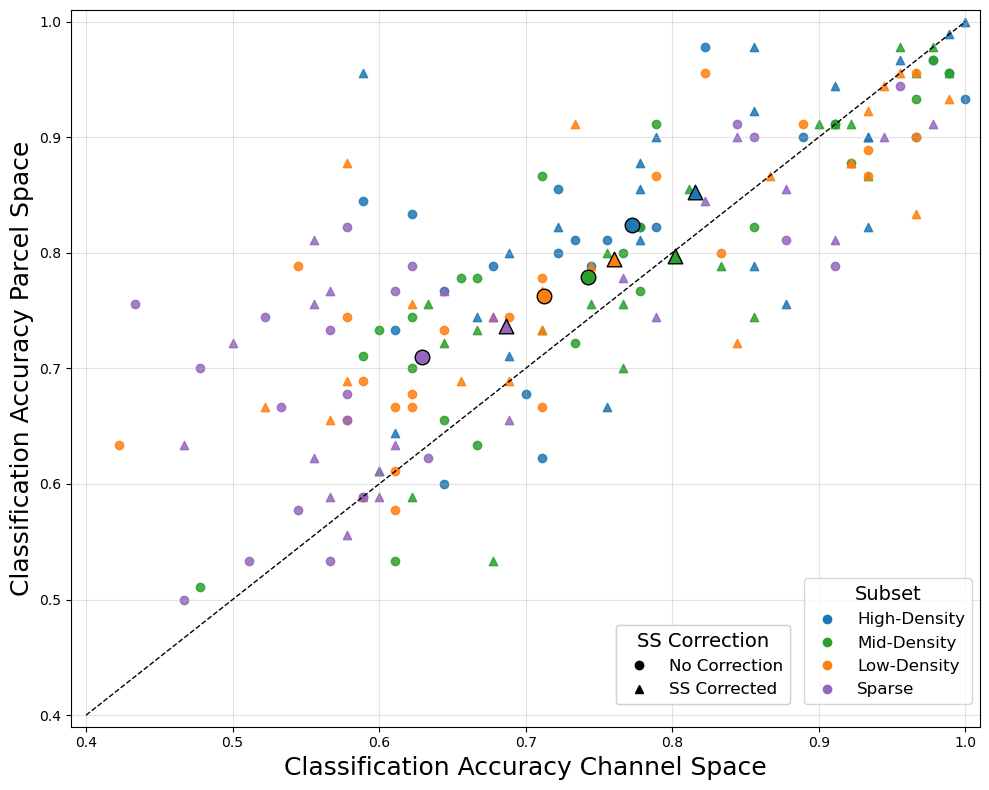

Done.


In [ ]:
# scatter_chan_vs_parcel_pooled.py
# Deterministic loader + pooled WS/LOSO scatter plots.
# Colors = channel subsets; Markers: o = No-SS, ^ = SS

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

RESULT_ROOT = "/home/thomas/Dokumente/Master/Master_Thesis/HD-DOT_Classification/results"
DATASETS = ["HD_Squeezing", "BS_Laura"]
#DATASETS = ["BS_Laura"]
#DATASETS = ["HD_Squeezing"]
SUBSETS = ["full", "subset_1", "subset_2", "subset_3"] 
subset_names = {"full": "High-Density", "subset_1": "Mid-Density", "subset_2": "Low-Density", "subset_3": "Sparse"}

DT_CH_WS   = {"no_ss": "all",       "ss": "all_ss_mean"}
DT_CH_LOSO = {"no_ss": "all",       "ss": "all_ss_mean"}
DT_PC_WS   = {"no_ss": "all_od",    "ss": "all_od_ss_mean"}
DT_PC_LOSO = {"no_ss": "all_od",    "ss": "all_od_ss_mean"}

FT        = "ft_Slope"
CLF       = "clf_Linear_SVM"
#CLF       = "clf_LDA"
INT_SCAL  = "01"
SP_SCAL   = "1"

PRUNE_WS   = "prune_ch_sma_True"
PRUNE_LOSO = "prune_ch_sma_False"
#HRF_WS     = "sel_hrf_15"
HRF_LOSO   = "sel_hrf_None"

# Parcel subset-name in filenames (dataset-specific)
PARCEL_WS_SUBNAME   = {"HD_Squeezing": "SomMotA",   "BS_Laura": "SomMotA"}
PARCEL_LOSO_SUBNAME = {"HD_Squeezing": "sensitive", "BS_Laura": "sensitive"}

# where to save figures
SAVE_DIR = f"/home/thomas/Dokumente/Master/Master_Thesis/HD-DOT_Classification/writing/images/chan_vs_parcel/sparse_to_hd/scatter/{CLF}/{DATASETS}"
os.makedirs(SAVE_DIR, exist_ok=True)

# simple palette per subset
SUBSET_COLORS = {
    "full": "#1f77b4", "subset_1": "#2ca02c", "subset_2": "#ff7f0e", "subset_3": "#9467bd"
}
# ---------------------------------------------------------------------


def read_series(path):
    df = pd.read_csv(path)
    df = df[df["subject"] != "__ALL__"]
    return df.set_index("subject")["mean_acc"].astype(float)


def path_channel_ws(dataset, dt, subset):
    return os.path.join(
        RESULT_ROOT, dataset, "channel_space", "ws", FT, CLF, PRUNE_WS, HRF_WS,
        f"results_{dt}_{subset}.csv"
    )

def path_channel_loso(dataset, dt, subset):
    return os.path.join(
        RESULT_ROOT, dataset, "channel_space", "loso", FT, CLF, PRUNE_LOSO, HRF_LOSO,
        f"results_{dt}_{subset}.csv"
    )

def path_parcel_ws(dataset, dt, subset):
    subname = PARCEL_WS_SUBNAME[dataset]
    return os.path.join(
        RESULT_ROOT, dataset, "parcel_space", "ws", FT, CLF, PRUNE_LOSO, HRF_WS,
        f"results_{dt}_{subname}_chset_{subset}.csv"
    )

def path_parcel_loso(dataset, dt, subset):
    subname = PARCEL_LOSO_SUBNAME[dataset]
    return os.path.join(
        RESULT_ROOT, dataset, "parcel_space", "loso", FT, CLF, PRUNE_LOSO, HRF_LOSO,
        f"results_{dt}_{subname}_chset_{subset}.csv"
    )

def paired_points(ch_series, pc_series):
    common = ch_series.index.intersection(pc_series.index)
    return pd.DataFrame({"chan": ch_series.loc[common].values,
                         "parcel": pc_series.loc[common].values}, index=common)

def concat_pairs(list_of_dfs):
    if not list_of_dfs:
        return pd.DataFrame(columns=["chan","parcel"])
    return pd.concat(list_of_dfs, axis=0)

def plot_pooled(mode, pairs_no_ss_by_subset, pairs_ss_by_subset, save_name_suffix="pooled"):
    fig, ax = plt.subplots(figsize=(10, 8))

    # ---- Punkte plotten (ohne Legenden-Labels) ------------------------
    for subset in SUBSETS:
        df_no = pairs_no_ss_by_subset.get(subset, pd.DataFrame())
        if not df_no.empty:
            ax.scatter(
                df_no["chan"], df_no["parcel"],
                color=SUBSET_COLORS[subset],
                alpha=0.85,
                marker="o",
                label=None
            )

        df_ss = pairs_ss_by_subset.get(subset, pd.DataFrame())
        if not df_ss.empty:
            ax.scatter(
                df_ss["chan"], df_ss["parcel"],
                color=SUBSET_COLORS[subset],
                alpha=0.85,
                marker="^",
                label=None
            )

    # y = x Referenzlinie
    x_vals = np.linspace(0.4, 1.0, 200)
    ax.plot(x_vals, x_vals, "k--", linewidth=1)

    mean_marker_size = 110
    for subset in SUBSETS:
        df_no = pairs_no_ss_by_subset.get(subset, pd.DataFrame())
        if not df_no.empty:
            ax.scatter(
                df_no["chan"].mean(), df_no["parcel"].mean(),
                color=SUBSET_COLORS[subset],
                edgecolor="black",
                s=mean_marker_size,
                marker="o",
                zorder=5,
                label=None
            )

        df_ss = pairs_ss_by_subset.get(subset, pd.DataFrame())
        if not df_ss.empty:
            ax.scatter(
                df_ss["chan"].mean(), df_ss["parcel"].mean(),
                color=SUBSET_COLORS[subset],
                edgecolor="black",
                s=mean_marker_size,
                marker="^",
                zorder=5,
                label=None
            )

    # ---- Achsen / Titel -----------------------------------------------
    prefix = "WS" if mode == "ws" else "LOSO"
    #ax.set_xlabel(f"{prefix} Classification Accuracy Channel Space", fontsize=18)
    #ax.set_ylabel(f"{prefix} Classification Accuracy Parcel Space", fontsize=18)
    ax.set_xlabel(f"Classification Accuracy Channel Space", fontsize=18)
    ax.set_ylabel(f"Classification Accuracy Parcel Space", fontsize=18)
    ax.set_xlim(0.39, 1.01)
    ax.set_ylim(0.39, 1.01)
    ax.grid(True, alpha=0.35)
    #ax.set_title(
    #    #f"Channel vs Parcel — {prefix} - {CLF} - {DATASETS} - (All Subjects)",
    #    "Channel vs Parcel Space Classification Performance",
    #    fontsize=20,
    #    fontweight='bold'
    #)

    # ---- Custom-Legenden ----------------------------------------------
    # 1) Farben = Subsets
    subset_handles = [
        Line2D([0], [0],
               marker="o", linestyle="",
               color=SUBSET_COLORS[s],
               label=subset_names[s])
        for s in SUBSETS
    ]
    leg_subsets = ax.legend(
        handles=subset_handles,
        title="Subset",
        loc="lower right",
        bbox_to_anchor=(1.00, 0.02),
        frameon=True,
        fontsize=12,
        title_fontsize=14
    )
    ax.add_artist(leg_subsets)

    # 2) Markerform = No SS / SS
    ss_handles = [
        Line2D([0], [0],
               marker="o", linestyle="",
               color="black",
               label="No Correction"),
        Line2D([0], [0],
               marker="^", linestyle="",
               color="black",
               label="SS Corrected")
    ]
    leg_ss = ax.legend(
        handles=ss_handles,
        title="SS Correction",
        loc="lower right",
        bbox_to_anchor=(0.8, 0.02),
        frameon=True,
        fontsize=12,
        title_fontsize=14
    )
    ax.add_artist(leg_ss)

    # 3) Große Marker = Mean
    mean_handles = [
        Line2D([0], [0],
               marker="o", linestyle="",
               markersize=np.sqrt(mean_marker_size) / 2,
               markerfacecolor="white",
               markeredgecolor="black",
               label="Mean pro Gruppe")
    ]
    #leg_mean = ax.legend(
    #    handles=mean_handles,
    #    title="Aggregat",
    #    loc="lower right",
    #    bbox_to_anchor=(0.48, 0.02),
    #    frameon=True,
    #    fontsize=9,
    #    title_fontsize=10
    #)

    # Layout & Save
    plt.tight_layout()
    base = os.path.join(SAVE_DIR, f"scatter_{mode}_chan_vs_parcel_{save_name_suffix}")
    for ext in ["png", "pdf", "svg"]:
        fig.savefig(f"{base}.{ext}", dpi=300 if ext == "png" else None)
    plt.show()


# --------------- BUILD POOLED DATA -----------------------------------
# collect per-dataset, then pool by concatenation
pooled_ws_no_ss = {subset: [] for subset in SUBSETS}
pooled_ws_ss    = {subset: [] for subset in SUBSETS}
pooled_lo_no_ss = {subset: [] for subset in SUBSETS}
pooled_lo_ss    = {subset: [] for subset in SUBSETS}

for dataset in DATASETS:

    if dataset == "HD_Squeezing":
        HRF_WS = "sel_hrf_None"
    else:  
        HRF_WS = "sel_hrf_None"

    for subset in SUBSETS:
        # WS
        ch_ws_no = read_series(path_channel_ws(dataset, DT_CH_WS["no_ss"], subset))
        pc_ws_no = read_series(path_parcel_ws(dataset, DT_PC_WS["no_ss"], subset))
        pooled_ws_no_ss[subset].append(paired_points(ch_ws_no, pc_ws_no))

        ch_ws_ss = read_series(path_channel_ws(dataset, DT_CH_WS["ss"], subset))
        pc_ws_ss = read_series(path_parcel_ws(dataset, DT_PC_WS["ss"], subset))
        pooled_ws_ss[subset].append(paired_points(ch_ws_ss, pc_ws_ss))

        # LOSO
        ch_lo_no = read_series(path_channel_loso(dataset, DT_CH_LOSO["no_ss"], subset))
        pc_lo_no = read_series(path_parcel_loso(dataset, DT_PC_LOSO["no_ss"], subset))
        pooled_lo_no_ss[subset].append(paired_points(ch_lo_no, pc_lo_no))

        ch_lo_ss = read_series(path_channel_loso(dataset, DT_CH_LOSO["ss"], subset))
        pc_lo_ss = read_series(path_parcel_loso(dataset, DT_PC_LOSO["ss"], subset))
        pooled_lo_ss[subset].append(paired_points(ch_lo_ss, pc_lo_ss))

# concatenate across datasets
pooled_ws_no_ss = {k: concat_pairs(v) for k, v in pooled_ws_no_ss.items()}
pooled_ws_ss    = {k: concat_pairs(v) for k, v in pooled_ws_ss.items()}
pooled_lo_no_ss = {k: concat_pairs(v) for k, v in pooled_lo_no_ss.items()}
pooled_lo_ss    = {k: concat_pairs(v) for k, v in pooled_lo_ss.items()}

# --------------- PLOTS (POOLED) --------------------------------------
plot_pooled("ws",   pooled_ws_no_ss, pooled_ws_ss,   save_name_suffix="pooled")

print("Done.")


In [32]:
def build_long_dataframe(pooled_no_ss, pooled_ss, space_label):
    """
    pooled_no_ss / pooled_ss: dict(subset_name -> df with columns ["chan","parcel"])
    space_label: "channel" or "parcel"
    Returns long-format DataFrame.
    """
    rows = []
    
    for subset in SUBSETS:
        df_no = pooled_no_ss.get(subset, pd.DataFrame())
        df_ss = pooled_ss.get(subset, pd.DataFrame())
        
        # noSS
        if not df_no.empty:
            for subj, row in df_no.iterrows():
                rows.append({
                    "subject": subj,
                    "density": subset,
                    "ss": "noSS",
                    "space": space_label,
                    "mean_acc": row[space_label]  # either df["chan"] or df["parcel"]
                })
        
        # SS
        if not df_ss.empty:
            for subj, row in df_ss.iterrows():
                rows.append({
                    "subject": subj,
                    "density": subset,
                    "ss": "SS",
                    "space": space_label,
                    "mean_acc": row[space_label]
                })

    return pd.DataFrame(rows)

In [33]:
# Build long-format channel + parcel data
df_chan = build_long_dataframe(pooled_ws_no_ss, pooled_ws_ss, space_label="chan")
df_parc = build_long_dataframe(pooled_ws_no_ss, pooled_ws_ss, space_label="parcel")

df_long = pd.concat([df_chan, df_parc], ignore_index=True)

# Category ordering
df_long["density"] = pd.Categorical(df_long["density"], 
                                    categories=SUBSETS, ordered=True)
df_long["ss"] = pd.Categorical(df_long["ss"], 
                               categories=["noSS","SS"], ordered=True)
df_long["space"] = pd.Categorical(df_long["space"], 
                                  categories=["chan","parcel"], ordered=True)

In [38]:
print("\n================ DEBUG SUMMARY: df_long ==================\n")

# 1) Channel vs Parcel Space
print(">> Mean accuracy: SPACE (channel vs parcel)")
print(df_long.groupby("space")["mean_acc"].mean(), "\n")

# 2) SS vs noSS
print(">> Mean accuracy: SS correction (noSS vs SS)")
print(df_long.groupby("ss")["mean_acc"].mean(), "\n")

# 3) Density levels
print(">> Mean accuracy: Density levels")
print(df_long.groupby("density")["mean_acc"].mean(), "\n")

# 4) Optional: full 3-way summary
print(">> Mean accuracy by Density × SS × Space")
print(df_long.groupby(["density", "ss", "space"])["mean_acc"].mean(), "\n")


================ DEBUG SUMMARY: df_long ==================

>> Mean accuracy: SPACE (channel vs parcel)
space
chan      0.740152
parcel    0.782008
Name: mean_acc, dtype: float64 

>> Mean accuracy: SS correction (noSS vs SS)
ss
noSS    0.741477
SS      0.780682
Name: mean_acc, dtype: float64 

>> Mean accuracy: Density levels
density
full        0.816162
subset_1    0.780177
subset_2    0.757576
subset_3    0.690404
Name: mean_acc, dtype: float64 

>> Mean accuracy by Density × SS × Space
density   ss    space 
full      noSS  chan      0.772727
                parcel    0.823737
          SS    chan      0.815657
                parcel    0.852525
subset_1  noSS  chan      0.742424
                parcel    0.778788
          SS    chan      0.802020
                parcel    0.797475
subset_2  noSS  chan      0.712626
                parcel    0.762626
          SS    chan      0.760101
                parcel    0.794949
subset_3  noSS  chan      0.629293
                parcel    

In [34]:
from statsmodels.stats.anova import AnovaRM

print("\n====================== 4×2×2 rmANOVA (Density × SS × Space) ======================\n")

aov = AnovaRM(
    data=df_long,
    depvar="mean_acc",
    subject="subject",
    within=["density", "ss", "space"]
).fit()

print(aov)


====================== 4×2×2 rmANOVA (Density × SS × Space) ======================

                    Anova
                 F Value Num DF  Den DF Pr > F
----------------------------------------------
density          19.9364 3.0000 63.0000 0.0000
ss               25.0657 1.0000 21.0000 0.0001
space            11.1799 1.0000 21.0000 0.0031
density:ss        0.0798 3.0000 63.0000 0.9707
density:space     1.8592 3.0000 63.0000 0.1456
ss:space          6.4124 1.0000 21.0000 0.0194
density:ss:space  0.7429 3.0000 63.0000 0.5305



## LOSO Tables

In [ ]:
# ---- LOSO Accuracies-Table for FULL-Subset ----

subset = "full"
rows = []

for dataset in DATASETS:
    ch_lo_no = read_series(path_channel_loso(dataset, DT_CH_LOSO["no_ss"], subset))
    ch_lo_ss = read_series(path_channel_loso(dataset, DT_CH_LOSO["ss"], subset))
    pc_lo_no = read_series(path_parcel_loso(dataset, DT_PC_LOSO["no_ss"], subset))
    pc_lo_ss = read_series(path_parcel_loso(dataset, DT_PC_LOSO["ss"], subset))

    common = (
        ch_lo_no.index
        .intersection(ch_lo_ss.index)
        .intersection(pc_lo_no.index)
        .intersection(pc_lo_ss.index)
    )

    for subj in common:
        rows.append({
            "dataset":      dataset,
            "subject":      subj,
            "chan_no_ss":   ch_lo_no.loc[subj],
            "chan_ss":      ch_lo_ss.loc[subj],
            "parcel_no_ss": pc_lo_no.loc[subj],
            "parcel_ss":    pc_lo_ss.loc[subj],
        })

df_loso_full = pd.DataFrame(rows).sort_values(
    ["dataset", "subject"]
).reset_index(drop=True)

for col in ["chan_no_ss", "chan_ss", "parcel_no_ss", "parcel_ss"]:
    df_loso_full[col] = df_loso_full[col].round(2)

print(df_loso_full.to_string(index=False))

     dataset subject  chan_no_ss  chan_ss  parcel_no_ss  parcel_ss
    BS_Laura sub-577        0.57     0.64          0.60       0.64
    BS_Laura sub-580        0.56     0.63          0.63       0.71
    BS_Laura sub-586        0.79     0.79          0.86       0.88
    BS_Laura sub-587        0.88     0.95          0.86       0.93
    BS_Laura sub-592        0.45     0.50          0.67       0.67
    BS_Laura sub-613        0.83     0.76          0.90       0.88
    BS_Laura sub-618        0.67     0.67          0.50       0.69
    BS_Laura sub-619        0.76     0.71          0.76       0.83
    BS_Laura sub-621        0.69     0.69          0.69       0.71
    BS_Laura sub-633        0.86     0.93          0.88       1.00
    BS_Laura sub-638        0.78     0.70          0.73       0.76
    BS_Laura sub-640        0.74     0.76          0.71       0.79
HD_Squeezing sub-170        0.77     0.79          0.77       0.79
HD_Squeezing sub-173        0.79     0.83          0.82       

In [ ]:
from scipy.stats import ttest_rel
import pandas as pd


tests = {
    "chan_no_ss vs chan_ss":      ("chan_no_ss", "chan_ss"),
    "chan_no_ss vs parcel_no_ss": ("chan_no_ss", "parcel_no_ss"),
    "chan_no_ss vs parcel_ss":    ("chan_no_ss", "parcel_ss"),
}

results = []

for name, (a, b) in tests.items():
    t, p = ttest_rel(df_loso_full[a], df_loso_full[b])
    results.append({
        "comparison": name,
        "t_stat": t,
        "p_value": p
    })

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))


                comparison    t_stat  p_value
     chan_no_ss vs chan_ss -2.296481 0.032037
chan_no_ss vs parcel_no_ss -0.846507 0.406813
   chan_no_ss vs parcel_ss -4.188124 0.000414


In [30]:
df_loso_full['parcel_no_ss']

0     0.60
1     0.63
2     0.86
3     0.86
4     0.67
5     0.90
6     0.50
7     0.76
8     0.69
9     0.88
10    0.73
11    0.71
12    0.77
13    0.82
14    0.67
15    0.76
16    0.56
17    0.72
18    0.76
19    0.89
20    0.71
21    0.99
Name: parcel_no_ss, dtype: float64

In [31]:
def make_latex_table_loso_full(df_loso_full):
    df = df_loso_full[[
        "dataset", "subject",
        "chan_no_ss", "chan_ss",
        "parcel_no_ss", "parcel_ss"
    ]].copy()

    if df["dataset"].nunique() == 1:
        df = df.sort_values("subject")
        labels = df["subject"].astype(str).tolist()
    else:
        df = df.sort_values(["dataset", "subject"])
        labels = (df["dataset"].astype(str) + "-" + df["subject"].astype(str)).tolist()

    chan_no = (df["chan_no_ss"].values * 100)
    chan_ss = (df["chan_ss"].values * 100)
    parc_no = (df["parcel_no_ss"].values * 100)
    parc_ss = (df["parcel_ss"].values * 100)

    m_chan_no = chan_no.mean()
    m_chan_ss = chan_ss.mean()
    m_parc_no = parc_no.mean()
    m_parc_ss = parc_ss.mean()

    n = len(labels)
    col_spec = "l" + "c" * (n + 1)

    header_subjects = " & " + " & ".join([f"\\textbf{{{s}}}" for s in labels]) \
                      + " & $\\mathbf{\\bar{x}}$ \\\\"

    def bold_best(a, b, c, d):
        cols = []
        for i in range(len(a)):
            vals = [a[i], b[i], c[i], d[i]]
            best = max(vals)
            def fmt(x):
                s = f"{int(round(x))}"
                return f"\\textbf{{{s}}}" if x == best else s
            cols.append([fmt(a[i]), fmt(b[i]), fmt(c[i]), fmt(d[i])])
        return list(zip(*cols))

    rowA, rowB, rowC, rowD = bold_best(chan_no, chan_ss, parc_no, parc_ss)

    row_chan_no = " & " + " & ".join(rowA) + f" & \\textbf{{{m_chan_no:.1f}}} \\\\"
    row_chan_ss = " & " + " & ".join(rowB) + f" & \\textbf{{{m_chan_ss:.1f}}} \\\\"
    row_parc_no = " & " + " & ".join(rowC) + f" & \\textbf{{{m_parc_no:.1f}}} \\\\"
    row_parc_ss = " & " + " & ".join(rowD) + f" & \\textbf{{{m_parc_ss:.1f}}} \\\\"

    latex = []
    latex.append("\\begin{table}[htbp]")
    latex.append("\\centering")
    latex.append("\\huge")
    latex.append("\\begin{adjustbox}{max width=\\textwidth}")
    latex.append(f"\\begin{{tabular}}{{{col_spec}}}")
    latex.append("\\toprule")
    latex.append("\\textbf{Subject}" + header_subjects)
    latex.append("\\midrule")
    latex.append("\\textbf{Channel No SS}" + row_chan_no)
    latex.append("\\textbf{Channel SS}" + row_chan_ss)
    latex.append("\\textbf{Parcel No SS}" + row_parc_no)
    latex.append("\\textbf{Parcel SS}" + row_parc_ss)
    latex.append("\\bottomrule")
    latex.append("\\end{tabular}")
    latex.append("\\end{adjustbox}")
    latex.append("\\caption{LOSO classification accuracy (in \\%) für full channel set.}")
    latex.append("\\label{tab:loso_full_all_four}")
    latex.append("\\end{table}")

    print("\n".join(latex))


make_latex_table_loso_full(df_loso_full)

\begin{table}[htbp]
\centering
\huge
\begin{adjustbox}{max width=\textwidth}
\begin{tabular}{lccccccccccccccccccccccc}
\toprule
\textbf{Subject} & \textbf{BS_Laura-sub-577} & \textbf{BS_Laura-sub-580} & \textbf{BS_Laura-sub-586} & \textbf{BS_Laura-sub-587} & \textbf{BS_Laura-sub-592} & \textbf{BS_Laura-sub-613} & \textbf{BS_Laura-sub-618} & \textbf{BS_Laura-sub-619} & \textbf{BS_Laura-sub-621} & \textbf{BS_Laura-sub-633} & \textbf{BS_Laura-sub-638} & \textbf{BS_Laura-sub-640} & \textbf{HD_Squeezing-sub-170} & \textbf{HD_Squeezing-sub-173} & \textbf{HD_Squeezing-sub-174} & \textbf{HD_Squeezing-sub-176} & \textbf{HD_Squeezing-sub-177} & \textbf{HD_Squeezing-sub-179} & \textbf{HD_Squeezing-sub-181} & \textbf{HD_Squeezing-sub-182} & \textbf{HD_Squeezing-sub-183} & \textbf{HD_Squeezing-sub-185} & $\mathbf{\bar{x}}$ \\
\midrule
\textbf{Channel No SS} & 57 & 56 & 79 & 88 & 45 & 83 & 67 & 76 & 69 & 86 & \textbf{78} & 74 & 77 & 79 & 62 & 77 & 56 & 71 & 70 & 89 & 77 & \textbf{100} & \textbf{73.5

# 2x4 repeated-measures ANOVA (Density x SS) for WS Channel


In [ ]:

import os
import pandas as pd
from statsmodels.stats.anova import AnovaRM


BASE_DIR_WHOLE_HEAD = "/home/thomas/Dokumente/Master/Master_Thesis/HD-DOT_Classification/results/BS_Laura/channel_space/ws/ft_Slope/clf_Linear_SVM/prune_ch_sma_True/sel_hrf_20/"
BASE_DIR_MOTOR_ONLY = "/home/thomas/Dokumente/Master/Master_Thesis/HD-DOT_Classification/results/HD_Squeezing/channel_space/ws/ft_Slope/clf_Linear_SVM/prune_ch_sma_True/sel_hrf_None/"

DENSITY_ORDER = ["subset_3", "subset_2", "subset_1", "full"]

FILE_MAP = {
    ("full",      "noSS"): "results_all_full.csv",
    ("subset_1",  "noSS"): "results_all_subset_1.csv",
    ("subset_2",  "noSS"): "results_all_subset_2.csv",
    ("subset_3",  "noSS"): "results_all_subset_3.csv",
    ("full",      "SS"):   "results_all_ss_mean_full.csv",
    ("subset_1",  "SS"):   "results_all_ss_mean_subset_1.csv",
    ("subset_2",  "SS"):   "results_all_ss_mean_subset_2.csv",
    ("subset_3",  "SS"):   "results_all_ss_mean_subset_3.csv",
}


def load_long_format(base_dir: str, dataset_label: str) -> pd.DataFrame:
    """
    Lädt alle CSVs für ein Dataset (ganzer Head oder Motor-only) und
    gibt einen DataFrame im Long-Format zurück:

        columns: [subject, dataset, density, ss, mean_acc]

    Dabei werden "__ALL__"-Zeilen entfernt.
    """
    rows = []

    for (density, ss_flag), filename in FILE_MAP.items():
        csv_path = os.path.join(base_dir, filename)

        if not os.path.isfile(csv_path):
            raise FileNotFoundError(f"Datei nicht gefunden: {csv_path}")

        df = pd.read_csv(csv_path)

        df = df[df["subject"] != "__ALL__"].copy()

        df["density"] = density
        df["ss"] = ss_flag
        df["dataset"] = dataset_label

        rows.append(df[["subject", "dataset", "density", "ss", "mean_acc"]])

    long_df = pd.concat(rows, ignore_index=True)

    long_df["density"] = pd.Categorical(
        long_df["density"],
        categories=DENSITY_ORDER,
        ordered=True,
    )
    long_df["ss"] = pd.Categorical(
        long_df["ss"],
        categories=["noSS", "SS"],
        ordered=True,
    )

    return long_df


def run_2x4_rm_anova(df: pd.DataFrame, dataset_label: str):
    """
    Führt eine 2x4 rmANOVA (Density x SS) auf mean_acc durch.
    """
    print("=" * 80)
    print(f"2x4 rmANOVA für Dataset: {dataset_label}")
    print("=" * 80)

    aov = AnovaRM(
        data=df,
        depvar="mean_acc",
        subject="subject",
        within=["density", "ss"]
    ).fit()

    print(aov)


# Whole-head ball squeezing
df_whole = load_long_format(BASE_DIR_WHOLE_HEAD, dataset_label="whole_head")
run_2x4_rm_anova(df_whole, "whole_head")

print("\n\n")

# Motor-cortex-only ball squeezing
df_motor = load_long_format(BASE_DIR_MOTOR_ONLY, dataset_label="motor_only")
run_2x4_rm_anova(df_motor, "motor_only")



2x4 rmANOVA für Dataset: whole_head
                 Anova
           F Value Num DF  Den DF Pr > F
----------------------------------------
density    15.7418 3.0000 33.0000 0.0000
ss          7.8903 1.0000 11.0000 0.0170
density:ss  0.3845 3.0000 33.0000 0.7648




2x4 rmANOVA für Dataset: motor_only
                 Anova
           F Value Num DF  Den DF Pr > F
----------------------------------------
density    21.2978 3.0000 27.0000 0.0000
ss         19.3218 1.0000  9.0000 0.0017
density:ss  0.2471 3.0000 27.0000 0.8626



# Sequential improvement analysis

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, wilcoxon
from statsmodels.stats.anova import AnovaRM

def compute_step_deltas(long_df):
    """
    Erwartet long_df mit Spalten:
    subject, density, ss, mean_acc

    Density-Reihenfolge (von sparse → dense):
        subset_3, subset_2, subset_1, full

    Schritte:
        Δ1 = subset_2 - subset_3
        Δ2 = subset_1 - subset_2
        Δ3 = full     - subset_1
    """
    step_rows = []

    density_levels = ["subset_3", "subset_2", "subset_1", "full"]

    for ss_level in long_df["ss"].unique():
        df_ss = long_df[long_df["ss"] == ss_level]

        for subject in df_ss["subject"].unique():
            df_sub = df_ss[df_ss["subject"] == subject].set_index("density")

            acc = df_sub.loc[density_levels, "mean_acc"].values


            deltas = np.array([
                acc[1] - acc[0],   # Δ1 = subset_2 − subset_3
                acc[2] - acc[1],   # Δ2 = subset_1 − subset_2
                acc[3] - acc[2],   # Δ3 = full     − subset_1
            ])

            for i, d in enumerate(deltas):
                step_rows.append({
                    "subject": subject,
                    "ss": ss_level,
                    "step": f"Δ{i+1}",
                    "delta": d
                })

    return pd.DataFrame(step_rows)



def run_step_anova(delta_df, ss_level):
    df = delta_df[delta_df["ss"] == ss_level]

    print(f"\n============================")
    print(f" Step-Delta ANOVA (SS={ss_level})")
    print("============================")

    aov = AnovaRM(
        data=df,
        depvar="delta",
        subject="subject",
        within=["step"]
    ).fit()

    print(aov)

    # Post-hoc: pairwise comparisons
    steps = ["Δ1", "Δ2", "Δ3"]
    print("\nPost-hoc pairwise comparisons (paired t-tests):")
    for s1, s2 in [("Δ1", "Δ2"), ("Δ2", "Δ3"), ("Δ1", "Δ3")]:
        d1 = df[df["step"] == s1]["delta"]
        d2 = df[df["step"] == s2]["delta"]

        t, p = ttest_rel(d1, d2)
        print(f"{s1} vs {s2}: t={t:.3f}, p={p:.4f}")


# Whole-head ball squeezing
delta_df_whole = compute_step_deltas(long_df=df_whole)
print("Whole-head ball squeezing:")
print("No SS")
run_step_anova(delta_df_whole, ss_level="noSS")
print("\nWith SS")
run_step_anova(delta_df_whole, ss_level="SS")

print("\n\n")


# Motor-cortex-only ball squeezing
delta_df_motor = compute_step_deltas(long_df=df_motor)
print("Motor-cortex-only ball squeezing:")
print("No SS")
run_step_anova(delta_df_motor, ss_level="noSS")
print("\nWith SS")  
run_step_anova(delta_df_motor, ss_level="SS")


Whole-head ball squeezing:
No SS

 Step-Delta ANOVA (SS=noSS)
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
step  0.2793 2.0000 22.0000 0.7589


Post-hoc pairwise comparisons (paired t-tests):
Δ1 vs Δ2: t=0.323, p=0.7529
Δ2 vs Δ3: t=-0.826, p=0.4263
Δ1 vs Δ3: t=-0.388, p=0.7055

With SS

 Step-Delta ANOVA (SS=SS)
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
step  0.4343 2.0000 22.0000 0.6531


Post-hoc pairwise comparisons (paired t-tests):
Δ1 vs Δ2: t=-0.813, p=0.4333
Δ2 vs Δ3: t=0.565, p=0.5837
Δ1 vs Δ3: t=-0.498, p=0.6286



Motor-cortex-only ball squeezing:
No SS

 Step-Delta ANOVA (SS=noSS)
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
step 11.9943 2.0000 18.0000 0.0005


Post-hoc pairwise comparisons (paired t-tests):
Δ1 vs Δ2: t=2.957, p=0.0160
Δ2 vs Δ3: t=2.105, p=0.0646
Δ1 vs Δ3: t=4.168, p=0.0024

With SS

 Step-Delta ANOVA (SS=SS)
             

In [10]:
print("Motor-only: mean Deltas per Step and SS state")
motor_summary = (
    delta_df_motor
    .groupby(["ss", "step"])["delta"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

print(motor_summary)

print("\nWhole-head: mean Deltas per Step and SS state")
whole_summary = (
    delta_df_whole
    .groupby(["ss", "step"])["delta"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

print(whole_summary)

Motor-only: mean Deltas per Step and SS state
     ss step          mean       std  count
0    SS   Δ1  1.311111e-01  0.138362     10
1    SS   Δ2  2.222222e-02  0.031427     10
2    SS   Δ3 -8.888889e-03  0.020820     10
3  noSS   Δ1  1.333333e-01  0.092370     10
4  noSS   Δ2  3.000000e-02  0.042245     10
5  noSS   Δ3  3.330669e-17  0.015713     10

Whole-head: mean Deltas per Step and SS state
     ss step      mean       std  count
0    SS   Δ1  0.025926  0.093484     12
1    SS   Δ2  0.060185  0.065213     12
2    SS   Δ3  0.047222  0.075229     12
3  noSS   Δ1  0.041667  0.083434     12
4  noSS   Δ2  0.029630  0.068712     12
5  noSS   Δ3  0.057407  0.088361     12


## Synthetic Data 

In [3]:
import os
import pandas as pd
from statsmodels.stats.anova import AnovaRM
import warnings
warnings.filterwarnings("ignore")

# --------------------------------------------------------------------
# Configuration
# --------------------------------------------------------------------

BASE_DIR = "/home/thomas/Dokumente/Master/Master_Thesis/HD-DOT_Classification/results/Syn_Finger_Tapping/channel_space/ws/ft_Slope/clf_Linear_SVM/prune_ch_sma_True/sel_hrf_20/"

DENSITY_ORDER   = ["subset_3", "subset_2", "subset_1", "full"]
SS_ORDER        = ["noSS", "SS"]
SCALE_ORDER     = ["sp_1", "sp_2", "sp_3"]
INTENSITY_ORDER = ["int_01", "int_02", "int_03"]

def debug_summary(df: pd.DataFrame) -> None:
    """Print descriptive summaries to inspect SS and density effects."""

    print("\n================ BASIC STRUCTURE ================")
    print("Subjects:", df["subject"].nunique())
    print("Densities:", df["density"].cat.categories.tolist())
    print("SS levels:", df["ss"].cat.categories.tolist())
    print("Intensities:", df["intensity"].cat.categories.tolist())
    print("Scales:", df["scale"].cat.categories.tolist())

    # Overall mean by density and SS (averaged across all intensities and scales)
    print("\n====== Mean accuracy by DENSITY × SS (averaged over intensity × scale) ======")
    mean_density_ss = (
        df.groupby(["density", "ss"])["mean_acc"]
        .mean()
        .reset_index()
        .sort_values(["ss", "density"])
    )
    print(mean_density_ss.to_string(index=False))

    # Mean by density × scale × SS (averaged across intensities)
    print("\n====== Mean accuracy by DENSITY × SCALE × SS (averaged over intensities) ======")
    mean_density_scale_ss = (
        df.groupby(["density", "scale", "ss"])["mean_acc"]
        .mean()
        .reset_index()
        .sort_values(["ss", "scale", "density"])
    )
    print(mean_density_scale_ss.to_string(index=False))

    # Optional: detail per intensity for sanity check
    print("\n====== Mean accuracy by SS × DENSITY × INTENSITY (averaged over scales) ======")
    mean_ss_density_int = (
        df.groupby(["ss", "density", "intensity"])["mean_acc"]
        .mean()
        .reset_index()
        .sort_values(["ss", "intensity", "density"])
    )
    print(mean_ss_density_int.to_string(index=False))


# --------------------------------------------------------------------
# Data loading
# --------------------------------------------------------------------

def parse_filename(fname: str):
    """
    Parse synthetic result filename into (density, ss_flag, intensity, scale).

    Examples:
        results_all_full_int_01_sp_1.csv
        results_all_subset_1_int_01_sp_1.csv
        results_all_ss_mean_full_int_01_sp_1.csv
        results_all_ss_mean_subset_1_int_01_sp_1.csv
    """
    name = fname.replace(".csv", "")
    parts = name.split("_")

    if not parts[0] == "results" or not parts[1] == "all":
        return None  # not one of the expected result files

    ss_flag = "SS" if "ss" in parts else "noSS"

    # density
    if "full" in parts:
        density = "full"
    elif "subset" in parts:
        idx = parts.index("subset")
        density = f"subset_{parts[idx + 1]}"
    else:
        return None

    # intensity
    if "int" in parts:
        idx = parts.index("int")
        intensity = f"int_{parts[idx + 1]}"
    else:
        return None

    # scale
    if "sp" in parts:
        idx = parts.index("sp")
        scale = f"sp_{parts[idx + 1]}"
    else:
        return None

    return density, ss_flag, intensity, scale


def load_synthetic_results(base_dir: str = BASE_DIR) -> pd.DataFrame:
    """Load all synthetic CSVs into a single long-format DataFrame."""
    rows = []

    for fname in os.listdir(base_dir):
        if not fname.endswith(".csv"):
            continue

        parsed = parse_filename(fname)
        if parsed is None:
            continue

        density, ss_flag, intensity, scale = parsed
        path = os.path.join(base_dir, fname)
        #print(f"Loading {path}...")
        df = pd.read_csv(path)

        df = df[df["subject"] != "__ALL__"]

        for _, r in df.iterrows():
            rows.append(
                {
                    "subject":   r["subject"],
                    "mean_acc":  r["mean_acc"],
                    "density":   density,
                    "ss":        ss_flag,
                    "intensity": intensity,
                    "scale":     scale,
                    "filename":  fname,
                }
            )

    df_all = pd.DataFrame(rows)

    if df_all.empty:
        raise RuntimeError(f"No synthetic result rows loaded from {base_dir}. Check BASE_DIR and filenames.")

    df_all["density"]   = pd.Categorical(df_all["density"],   categories=DENSITY_ORDER,   ordered=True)
    df_all["ss"]        = pd.Categorical(df_all["ss"],        categories=SS_ORDER,        ordered=True)
    df_all["intensity"] = pd.Categorical(df_all["intensity"], categories=INTENSITY_ORDER, ordered=True)
    df_all["scale"]     = pd.Categorical(df_all["scale"],     categories=SCALE_ORDER,     ordered=True)

    return df_all


# --------------------------------------------------------------------
# A) 2×4 rmANOVA: Density × SS (averaged across all HRF configs)
# --------------------------------------------------------------------

def run_anova_density_ss(df: pd.DataFrame) -> None:
    """Run 2×4 rmANOVA on mean accuracy with factors Density × SS."""
    print("\n============================================================")
    print(" 2×4 rmANOVA: DENSITY × SS  (averaged across intensity × scale)")
    print("============================================================")

    df_mean = (
        df.groupby(["subject", "density", "ss"])["mean_acc"]
        .mean()
        .reset_index()
    )

    aov = AnovaRM(
        data=df_mean,
        depvar="mean_acc",
        subject="subject",
        within=["density", "ss"],
    ).fit()

    print(aov)


# --------------------------------------------------------------------
# B) 4×3 rmANOVA: Density × Scale (averaged across intensities)
#    Run separately for SS and noSS
# --------------------------------------------------------------------

def run_anova_density_scale(df: pd.DataFrame) -> None:
    """Run 4×3 rmANOVA on mean accuracy with factors Density × Scale, per SS level."""
    print("\n============================================================")
    print(" 4×3 rmANOVA: DENSITY × SCALE  (averaged across intensities)")
    print("============================================================")

    for ss_flag in SS_ORDER:
        print(f"\n--- SS = {ss_flag} ---")

        df_sub = df[df["ss"] == ss_flag].copy()

        df_mean = (
            df_sub.groupby(["subject", "density", "scale"])["mean_acc"]
            .mean()
            .reset_index()
        )

        aov = AnovaRM(
            data=df_mean,
            depvar="mean_acc",
            subject="subject",
            within=["density", "scale"],
        ).fit()

        print(aov)

def run_anova_density_scale_ss(df: pd.DataFrame) -> None:
    """
    Run 4×3×2 rmANOVA on mean accuracy with within-subject factors:
        Density (4) × Scale (3) × SS (2),
    averaging across HRF intensity levels.
    """
    print("\n============================================================")
    print(" 4×3×2 rmANOVA: DENSITY × SCALE × SS  (averaged across intensities)")
    print("============================================================")

    # Average across intensity for each subject × density × scale × ss
    df_mean = (
        df.groupby(["subject", "density", "scale", "ss"])["mean_acc"]
        .mean()
        .reset_index()
    )

    aov = AnovaRM(
        data=df_mean,
        depvar="mean_acc",
        subject="subject",
        within=["density", "scale", "ss"],
    ).fit()

    print(aov)

def run_anova_density_scale_int_ss(df: pd.DataFrame) -> None:
    """
    Run 4×3×2 rmANOVA on mean accuracy with within-subject factors:
        Density (4) × Scale (3) × SS (2),
    averaging across HRF intensity levels.
    """
    print("\n============================================================")
    print(" 4×3×3×2 rmANOVA: DENSITY × SCALE × INTENSITY × SS  (averaged across intensities)")
    print("============================================================")

    # Average across intensity for each subject × density × scale × ss
    df_mean = (
        df.groupby(["subject", "density", "scale", "intensity", "ss"])["mean_acc"]
        .mean()
        .reset_index()
    )

    aov = AnovaRM(
        data=df_mean,
        depvar="mean_acc",
        subject="subject",
        within=["density", "scale", "intensity", "ss"],
    ).fit()

    print(aov)



df = load_synthetic_results()
print("Loaded rows:", len(df))

run_anova_density_ss(df)
run_anova_density_scale(df)
run_anova_density_scale_ss(df)
run_anova_density_scale_int_ss(df)

debug_summary(df)

Loaded rows: 1008

 2×4 rmANOVA: DENSITY × SS  (averaged across intensity × scale)
                 Anova
           F Value Num DF  Den DF Pr > F
----------------------------------------
density     9.6927 3.0000 39.0000 0.0001
ss         11.1010 1.0000 13.0000 0.0054
density:ss  0.8284 3.0000 39.0000 0.4863


 4×3 rmANOVA: DENSITY × SCALE  (averaged across intensities)

--- SS = noSS ---
                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
density        9.8636 3.0000 39.0000 0.0001
scale         16.8656 2.0000 26.0000 0.0000
density:scale  3.9594 6.0000 78.0000 0.0017


--- SS = SS ---
                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
density        8.4269 3.0000 39.0000 0.0002
scale         27.9124 2.0000 26.0000 0.0000
density:scale  9.4112 6.0000 78.0000 0.0000


 4×3×2 rmANOVA: DENSITY × SCALE × SS  (averaged across intensities)
                    Anova
   